# Quantum Generative Adversarial Networks

A QGAN is the quantum version of a *Generative Adversarial Network*. These are a particular kind of deep learning model used to generate real-looking synthetic data (such as images).

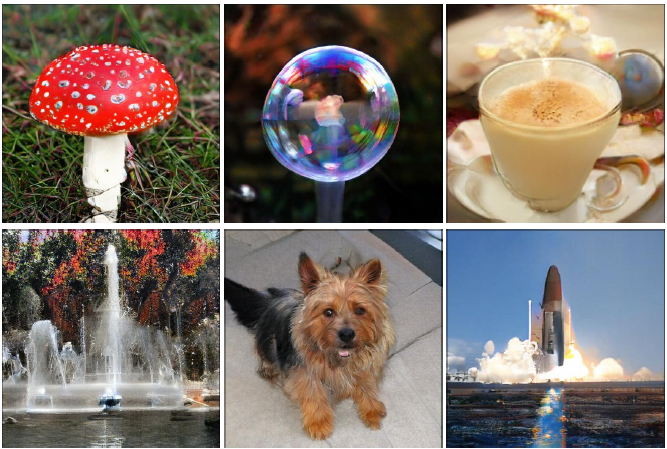

### GANs

> GANs have a unique structure, consisting of two models:

> - the **generator**: its goal is to produce realistic-looking data samples

> - the **discriminator**: its goal is distinguish fake data produced by the generator from real data

Training of GANs proceeds as follows:

1. "Real" data is captured in some *training dataset*.

2. The *generator* produces "fake" data by starting with a random input vector and transforming it into an output.

3. The *discriminator* is fed samples of both real and fake data and must decide which label to assign ('real' or 'fake').

4. Training consists of alternating steps: (i) the generator is frozen and the discriminator is trained to distinguish real from fake. (ii) the discriminator is frozen and the generator is trained to fool the discriminator. The gradient of the discriminator's output provides a training signal for the generator to improve its fake generated data. 

5. Eventually, this training method should converge to a stage where the generator is producing realistic data and the discriminator can't tell real from fake.

**Note:** Training is done via the *gradient descent* algorithm, updating only the weights associated with the generator (or vice versa) at each step. There is no internal structure imposed on the generator or discriminator models except that they are differentiable.

![Jupyter notebook icon](figures/gan1.png)

### Qauntum GANs

This demo walks through how to build and train a simple Quantum Generative Adversarial Network (QGAN) using PennyLane. Like classical GANs, QGANs consist of a generator and a discriminator. **QGANs use variational quantum circuits for both generator and discriminator.**

References: 

- [Lloyd and Weedbrook (2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.040502) 


- [Dallaire-Demers and Killoran (2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324)) 

**Note:** One of the areas where QGANs can provide a clear advantage is in modelling *quantum data*, i.e., data that is created by quantum systems. Quantum data distributions may be hard for classical models to emulate efficiently.

### PennyLane Execution

In [1]:
# lets first import the essentials
import pennylane as qml
from pennylane import numpy as np

In [2]:
# instantiate a device for the QGAN example
gan_dev = qml.device('default.qubit', wires=3)

In this QGAN example, we will use a quantum circuit to generate the real data- a qubit that has been rotated (from the starting state $\mid0\rangle$) to some arbitrary but fixed state. We will use the PennyLane [Rot](https://pennylane.readthedocs.io/en/latest/code/ops/qubit.html#pennylane.ops.qubit.Rot) operation.

In [3]:
def real(phi, theta, omega):
    qml.Rot(phi, theta, omega, wires=0)

For the generator and discriminator, we will choose the same basic circuit structure, but acting on different wires:

- Both the real data circuit and the generator will output on wire 0
- Wire 0 will be connected as an input to the discriminator
- Wire 1 is provided as a workspace for the generator
- The discriminator's output will be on wire 2

In [4]:
# Note: the structure of these circuits is more-or-less chosen arbitrarily. There is 
# nothing particular about these choices of generator or discriminator

def generator(w):
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)
    
def discriminator(w):
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[1,2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

We create two `QNodes`. One where the real data source is wired up to the discriminator and another where the generator is connected to the discriminator. They can both be run on the same device.

In [5]:
@qml.qnode(gan_dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real(phi, theta, omega)
#    discriminator(disc_weights)
    return qml.expval.PauliZ(2)

@qml.qnode(gan_dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval.PauliZ(2)

##### Cost function

There are two ingredients to the cost here:

1. the probability that the discriminator correctly **classifies real data as real.** 
2. the probability that the discriminator **classifies fake data (i.e., a state prepared by the generator) as real.** 

The discriminator's objective is to maximize the probability of correctly classifying real data, while minimizing the probability of mistakenly classifying fake data.

The generator's objective is to maximize the probability that the discriminator accepts fake data as real.

In [6]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert from expectation of Pauli-Z [-1,1] to probability [0,1] 
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert from expectation of Pauli-Z [-1,1] to probability [0,1]
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true # generator wants to minimize this prob

def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights) 
    return cost
# this ensures that prob_fake_true is minimized and prob_real_true is
# maximized to get the minimum (largest negative 0-1=-1) cost

def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights) 
# -ve sign ensures that gen_cost is minimum when prob_fake_true is close
# to 1 and the generator was able to fool the discriminator as intended

##### Optimization 

We initialize the fixed angles of the "real data" circuit as well as the initial parameters for both generator and discriminator. These are chosen so that the generator initially prepares a state on wire 0 that is very close to the $\mid1\rangle$ state.

In [7]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(1)
eps = 1e-2
gen_weights = np.array([np.pi] + [0] * 8) + np.random.normal(scale=eps, size=[9])
disc_weights = np.random.normal(size=[9])

In [8]:
# Create an optimizer
opt = qml.GradientDescentOptimizer(0.1)

In the first stage of training, we optimize the discriminator while keeping the generator parameters fixed.

In [9]:
for it in range(50):
    disc_weights = opt.step(disc_cost, disc_weights) 
    cost = disc_cost(disc_weights)
    if it % 5 == 0:
        print("Step {}: cost = {}".format(it+1, cost))

Step 1: cost = -0.6968864120481895
Step 6: cost = -0.8833291170857082
Step 11: cost = -0.9622277873352207
Step 16: cost = -0.9884645281702815
Step 21: cost = -0.9964573315639257
Step 26: cost = -0.9988464239391739
Step 31: cost = -0.9995681172734079
Step 36: cost = -0.9997922603205729
Step 41: cost = -0.9998648143641096
Step 46: cost = -0.9998895581303086


At the discriminator's optimum, the probability for the discriminator to correctly classify the real data should be close to one.

In [10]:
prob_real_true(disc_weights)

1.0

For comparison, we check how the discriminator classifies the generator's (still unoptimized) fake data:

In [11]:
prob_fake_true(gen_weights, disc_weights)

0.00010266209557718842

Following the adverserial training method, we have to now train the generator to better fool the discriminator.

In more complex settings, we can continue training the models in an alternating fashion until we reach the optimum point of the two-player adversarial game.

In [12]:
for it in range(200):
    gen_weights = opt.step(gen_cost, gen_weights)
    cost = -gen_cost(gen_weights)
    if it % 5 == 0:
        print("Step {}: cost = {}".format(it, cost))

Step 0: cost = 0.00011107868092574691
Step 5: cost = 0.00016565521511247017
Step 10: cost = 0.00024883127273001016
Step 15: cost = 0.000375571952737519
Step 20: cost = 0.0005686442459871266
Step 25: cost = 0.0008626464448956428
Step 30: cost = 0.0013100684881506286
Step 35: cost = 0.001990340855148154
Step 40: cost = 0.003023193633626464
Step 45: cost = 0.004588029831785467
Step 50: cost = 0.006951225025853658
Step 55: cost = 0.010502797801980712
Step 60: cost = 0.015801642050431164
Step 65: cost = 0.023622380634211848
Step 70: cost = 0.03498385472862875
Step 75: cost = 0.051117422146382985
Step 80: cost = 0.0733093341013975
Step 85: cost = 0.10255490845689808
Step 90: cost = 0.13904896781140308
Step 95: cost = 0.1817321615584001
Step 100: cost = 0.2282784068984718
Step 105: cost = 0.2757529771643312
Step 110: cost = 0.32166087289133827
Step 115: cost = 0.3647571877240606
Step 120: cost = 0.4052267448896536
Step 125: cost = 0.444327180897534
Step 130: cost = 0.48379523593280693
Step 13

At the optimum of the generator, the probability for the discriminator to be fooled should be close to 1.

In [13]:
prob_real_true(disc_weights)

1.0

In [14]:
prob_fake_true(gen_weights, disc_weights)

0.8562528122970663

At the joint optimum the overall cost will be close to zero.

In [15]:
disc_cost(disc_weights)

-0.1437471877029337

The generator has successfully learned how to simulate the real data enough to fool the discriminator!